# Remote STAC Catalogs

In order to load data products from remote [SpatioTemporal Asset Catalogs (STAC)](https://stacspec.org/en/), we can make use of the `load_from_stac`-function provided by the `sdc-tools` package. Currently, this function supports loading data products hosted by [Microsoft Planetary Computer (MPC)](https://planetarycomputer.microsoft.com/catalog) and [Digital Earth Africa (DEA)](https://explorer.digitalearth.africa/).


```{warning}
Up until now, we have worked with data products that are hosted on our local file servers. The loading of these is optimized by the `sdc-tools` package. In case of remote data products, **you are responsible** for choosing the right parameters for loading the data. An inappropriate choice can potentially lead to inefficient loading times and high memory usage, so please be aware of this. Create an issue or contact me directly if you have any questions.

Before loading a remote data product, you should get to know some of its basic characteristics. If you know the answer to at least the following questions, you are good to go:
- **What is the pixel spacing / resolution of the data?** 
    - Override the default `resolution` parameter if necessary.
- **Is the data categorical/discrete or continuous?** E.g., land cover is categorical, while spectral bands are continuous.
    - If the data is categorical you should override the default `resampling` method to `'nearest'`. [Here](https://gisgeography.com/raster-resampling) you can find a short summary of a few common resampling methods.
- **In which data type is the product stored and are there differences between the bands?** Common types are `uint8`, `uint16` and `float32`, for example. 
    - If there are differences in data types between the bands you're interested in, it's probably best to load these separately by specifiying the `bands` parameter and using the appropriate `dtype` for each band.

You should get an idea of how to handle these cases by having a look at the examples below. I also recommend you to read the guide on how to {ref}`override-defaults` if you haven't already.
```

```{note}
In both examples we will use the bounding box of an entire SALDi site as an example. If you have a specific area of interest, you can replace the bounding box with your own. E.g., by using the utility function `sdc.vec.get_vec_bounds` to generate a bounding box from a vector file.

In general it is recommended to test on a small subset first, before scaling up to larger areas and time periods.
```

## Import packages


In [ ]:
%matplotlib inline
import folium
import xarray as xr
from sdc.products.remote import load_from_stac
from sdc.vec import get_site_bounds

## Example: Planetary Computer

In this example, we load the `MCD64A1 Version 6.1 Burned Area data product` from MPC. You can find more details about this data product [here](https://planetarycomputer.microsoft.com/dataset/modis-64A1-061) on the MPC website and [here](https://lpdaac.usgs.gov/products/mcd64a1v061/) from the original data source, the USGS Land Processes Distributed Active Archive Center (LP DAAC).

In [2]:
bounds = get_site_bounds(site="site06")
time_range = ("2018", "2023")
override_defaults = {
    'crs': 'EPSG:4326', # this is already the default, but just to be explicit I wanted to show it here
    'resolution': 0.005, # equal to approx. 500 m pixel spacing, similar to the original data
    'resampling': 'nearest', # the data is categorical, so `nearest` resampling is appropriate!
    'chunks': {'time': 'auto', 'y': 'auto', 'x': 'auto'} # if you're not sure, you can set all to 'auto'
    } 

modis_burned = load_from_stac(
    stac_endpoint='pc',
    collection="modis-64A1-061",
    bounds=bounds,
    time_range=time_range,
    bands=["Burn_Date"],
    nodata=-1,
    dtype='int16',
    override_defaults=override_defaults
    )

modis_burned.Burn_Date

[INFO] odc.stac.load parameters: {'crs': 'EPSG:4326', 'resolution': 0.005, 'resampling': 'nearest', 'chunks': {'time': 'auto', 'y': 'auto', 'x': 'auto'}}


<xarray.DataArray 'Burn_Date' (time: 71, latitude: 220, longitude: 260)> Size: 8MB
dask.array<Burn_Date, shape=(71, 220, 260), dtype=int16, chunksize=(71, 220, 260), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 2kB -24.9 -24.91 -24.91 ... -25.99 -26.0
  * longitude    (longitude) float64 2kB 30.75 30.76 30.76 ... 32.04 32.04 32.05
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 568B 2018-01-01 2018-02-01 ... 2023-12-01
Attributes:
    nodata:   -1

 The MODIS Burn Date product has fill values below 0. Let's set these to 0, calculate the average, per-pixel burn date for the year 2020 and plot the result on a map.

In [3]:
mbd = xr.where(modis_burned.Burn_Date > 0, modis_burned.Burn_Date, 0)

mbd_mean_2020 = mbd.sel(time='2020').mean(dim='time')
mbd_mean_2020

<xarray.DataArray 'Burn_Date' (latitude: 220, longitude: 260)> Size: 458kB
dask.array<mean_agg-aggregate, shape=(220, 260), dtype=float64, chunksize=(220, 260), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 2kB -24.9 -24.91 -24.91 ... -25.99 -26.0
  * longitude    (longitude) float64 2kB 30.75 30.76 30.76 ... 32.04 32.04 32.05
    spatial_ref  int32 4B 4326
Attributes:
    nodata:   -1

In [4]:
m = folium.Map()
mbd_mean_2020.odc.add_to(m, cmap='inferno', opacity=0.5)

m.fit_bounds(mbd_mean_2020.odc.map_bounds())
display(m)

## Example: Digital Earth Africa

This example demonstrates how to load a cropland extent map created by DEA. The data explorer linked in the beginning of this notebook lists multiple `crop_mask` products for different regions of Africa. We will load the product `crop_mask_southern`, which covers all of South Africa as you can see [here](https://explorer.digitalearth.africa/products/crop_mask_southern). More details about the data product itself can be found [here](https://docs.digitalearthafrica.org/en/latest/data_specs/Cropland_extent_specs.html) and [here](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Datasets/Cropland_extent.html).

In [ ]:
from sdc.products.remote import load_from_stac
from sdc.vec import get_site_bounds

bounds = get_site_bounds(site="site04")
time_range = ("2019", "2019") # only a mask for the year 2019 is available
override_defaults = {
    'crs': 'EPSG:4326', # this is already the default, but just to be explicit I wanted to show it here
    'resolution': 0.0001, # equal to approx. 10 m pixel spacing, similar to the original data
    'resampling': 'nearest', # the data is categorical, so `nearest` resampling is appropriate!
    'chunks': {'time': -1, 'y': -1, 'x': -1} # single time slice and the small dtype (uint8), so loading it into one chunk should be fine
    } 

crop_2019 = load_from_stac(
    stac_endpoint='deafrica',
    collection="crop_mask_southern",
    bounds=bounds,
    time_range=time_range,
    bands=["mask", "prob"], # both of these bands have the same dtype and nodata value!
    nodata=0,
    dtype='uint8',
    override_defaults=override_defaults
    )

crop_2019.mask

[INFO] odc.stac.load parameters: {'crs': 'EPSG:4326', 'resolution': 0.0001, 'resampling': 'nearest', 'chunks': {'time': -1, 'y': -1, 'x': -1}}


<xarray.DataArray 'mask' (time: 1, latitude: 10000, longitude: 10500)> Size: 105MB
dask.array<mask, shape=(1, 10000, 10500), dtype=uint8, chunksize=(1, 10000, 10500), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 80kB -29.0 -29.0 -29.0 ... -30.0 -30.0 -30.0
  * longitude    (longitude) float64 84kB 26.45 26.45 26.45 ... 27.5 27.5 27.5
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 8B 2019-01-01
Attributes:
    nodata:   0

Only one time step is available representing the year 2019, but the data is loaded as a 3-dimensional array as you can see in the representation above.
We can drop the unnecessary time-dimension using the [`squeeze`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.squeeze.html#xarray.Dataset.squeeze) method:

In [14]:
crop_2019 = crop_2019.squeeze()
crop_2019.mask

<xarray.DataArray 'mask' (latitude: 10000, longitude: 10500)> Size: 105MB
dask.array<getitem, shape=(10000, 10500), dtype=uint8, chunksize=(10000, 10500), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 80kB -29.0 -29.0 -29.0 ... -30.0 -30.0 -30.0
  * longitude    (longitude) float64 84kB 26.45 26.45 26.45 ... 27.5 27.5 27.5
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2019-01-01
Attributes:
    nodata:   0

Finally, let's create a quick plot of the crop mask. The value `1` represents the presence of crops and `0` the absence:

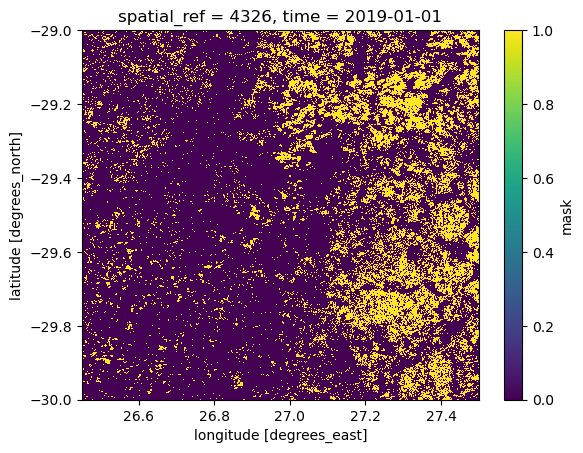

In [17]:
crop_2019.mask.plot()